# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups   
Sample_045  A0A0B4J1Y8          18.092
Sample_161  P45877              18.085
Sample_028  Q7Z7H5;Q7Z7H5-3     14.607
Sample_093  A0A087WWF1;Q8WWX9   15.134
Sample_045  P22304              16.614
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups        
Sample_172  P80188;P80188-2;X6R8F3   13.581
Sample_092  S4R3U6                    9.704
Sample_188  Q9NZR2                   11.960
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.522
            A0A075B6Q5                 13.229
            A0A075B6R2                 12.063
            A0A075B6S5                 13.426
            A0A087WSY4                 12.260
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.422
            Q9UI40;Q9UI40-2            13.150
            Q9UIW2                     12.286
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.037
            Q9UP79                     13.988
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.649,15.050,16.842,19.863,13.271,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,13.905,19.067,...,15.528,15.576,12.023,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.837,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.014,17.705,17.039,14.492,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.249,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.068,15.345,17.084,18.708,14.249,19.433,10.570,9.396
Sample_207,15.739,16.877,15.469,16.898,13.685,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.522,...,16.012,15.178,12.153,15.050,16.842,19.863,13.414,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.568,19.067,16.188,...,15.528,15.576,12.843,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.510,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.425,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.877,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.677,15.345,17.084,18.708,14.249,19.433,12.805,12.668
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 307.07it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.75it/s]

100%|██████████| 3/3 [00:00<00:00,  4.23it/s]

100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

100%|██████████| 4/4 [00:01<00:00,  3.59it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.08it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.38it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

100%|██████████| 5/5 [00:02<00:00,  2.27it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.43it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.25it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.82it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.53it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.92it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.90it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.72it/s]

100%|██████████| 7/7 [00:02<00:00,  2.57it/s]

100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.44it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.45it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.52it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.55it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.54it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.69it/s]

100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.63it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.86it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.47it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.05it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.88it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.81it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.59it/s]

100%|██████████| 9/9 [00:02<00:00,  2.82it/s]

100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.55it/s]

 30%|███       | 3/10 [00:00<00:01,  4.85it/s]

 40%|████      | 4/10 [00:00<00:01,  3.63it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.56it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.25it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.11it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.20it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.19it/s]

100%|██████████| 10/10 [00:04<00:00,  2.12it/s]

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.91it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.79it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.33it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.21it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.28it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.30it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.29it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.32it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.41it/s]

100%|██████████| 11/11 [00:04<00:00,  2.54it/s]

100%|██████████| 11/11 [00:04<00:00,  2.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.07it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.21it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.89it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.61it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.59it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.58it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.66it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.65it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.60it/s]

100%|██████████| 12/12 [00:04<00:00,  2.69it/s]

100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.58it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.09it/s]

 31%|███       | 4/13 [00:01<00:02,  3.58it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.13it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.00it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.97it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.88it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.82it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.84it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.63it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.30it/s]

100%|██████████| 13/13 [00:04<00:00,  2.24it/s]

100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.68it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.31it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.48it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.12it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.05it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.98it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.90it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.91it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.81it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.49it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.24it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.09it/s]

100%|██████████| 14/14 [00:05<00:00,  2.08it/s]

100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.45it/s]

 20%|██        | 3/15 [00:00<00:03,  3.77it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.44it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.22it/s]

 40%|████      | 6/15 [00:01<00:02,  3.09it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.91it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.70it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.28it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.19it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.06it/s]

 80%|████████  | 12/15 [00:04<00:01,  1.94it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.94it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.04it/s]

100%|██████████| 15/15 [00:06<00:00,  2.29it/s]

100%|██████████| 15/15 [00:06<00:00,  2.47it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.000      0.048 0.003          0.643 0.420       0.092   
2             0.004 0.002      0.060 0.018          0.675 0.122       0.523   
3             0.005 0.003      0.064 0.025          0.717 0.091       0.669   
4             0.004 0.000      0.050 0.010          0.731 0.095       0.717   
5             0.004 0.001      0.060 0.016          0.752 0.099       0.723   
6             0.005 0.004      0.068 0.026          0.742 0.088       0.724   
7             0.004 0.002      0.050 0.016          0.735 0.092       0.725   
8             0.005 0.003      0.057 0.019          0.751 0.081       0.760   
9             0.005 0.004      0.065 0.025          0.801 0.083       0.792   
10            0.004 0.000      0.047 0.009          0.800 0.079       0.804   
11            0.004 0.001      0.051 0.013          0.795 0.080       0.796   
12            0.006 0.005      0.074 0.029          0.795 0.083       0.794   
13            0.006 0.006      0.066 0.022          0.799 0.081       0.792   
14            0.005 0.002      0.057 0.017          0.798 0.083       0.789   
15            0.006 0.004      0.054 0.013          0.803 0.081       0.797   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.154 0.127                  0.538 0.038        0.853   
2          0.111   0.581 0.090                  0.665 0.065        0.718   
3          0.115   0.687 0.089                  0.737 0.070        0.826   
4          0.103   0.720 0.082                  0.760 0.069        0.853   
5          0.104   0.731 0.079                  0.771 0.065        0.850   
6          0.108   0.728 0.080                  0.768 0.065        0.853   
7          0.110   0.725 0.082                  0.765 0.067        0.850   
8          0.105   0.751 0.073                  0.787 0.060        0.857   
9          0.109   0.791 0.071                  0.822 0.058        0.905   
10         0.095   0.798 0.069                  0.827 0.059        0.909   
11         0.094   0.792 0.069                  0.822 0.057        0.909   
12         0.094   0.790 0.069                  0.821 0.057        0.907   
13         0.095   0.792 0.070                  0.823 0.058        0.905   
14         0.096   0.790 0.071                  0.821 0.060        0.905   
15         0.094   0.796 0.068                  0.826 0.057        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.821 0.089        210.000 0.000  
2          0.081                  0.669 0.101        210.000 0.000  
3          0.059                  0.769 0.087        210.000 0.000  
4          0.056                  0.812 0.080        210.000 0.000  
5          0.055                  0.803 0.079        210.000 0.000  
6          0.052                  0.801 0.075        210.000 0.000  
7          0.053                  0.796 0.075        210.000 0.000  
8          0.055                  0.815 0.075        210.000 0.000  
9          0.048                  0.877 0.064        210.000 0.000  
10         0.049                  0.892 0.054        210.000 0.000  
11         0.049                  0.893 0.053        210.000 0.000  
12         0.050                  0.891 0.054        210.000 0.000  
13         0.051                  0.888 0.057        210.000 0.000  
14         0.051                  0.888 0.058        210.000 0.000  
15         0.051                  0.886 0.058 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 474.68it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.85it/s]

100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.43it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.10it/s]

100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.06it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.11it/s]

 80%|████████  | 4/5 [00:02<00:00,  1.72it/s]

100%|██████████| 5/5 [00:02<00:00,  1.61it/s]

100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  2.69it/s]

 50%|█████     | 3/6 [00:01<00:01,  1.69it/s]

 67%|██████▋   | 4/6 [00:02<00:01,  1.61it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.61it/s]

100%|██████████| 6/6 [00:03<00:00,  1.68it/s]

100%|██████████| 6/6 [00:03<00:00,  1.72it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.55it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.23it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.89it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.67it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.44it/s]

100%|██████████| 7/7 [00:02<00:00,  2.53it/s]

100%|██████████| 7/7 [00:02<00:00,  2.74it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.68it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.67it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.53it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.45it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.98it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.80it/s]

100%|██████████| 8/8 [00:03<00:00,  1.85it/s]

100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.85it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.40it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.03it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.83it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.90it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.90it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.89it/s]

100%|██████████| 9/9 [00:04<00:00,  1.88it/s]

100%|██████████| 9/9 [00:04<00:00,  2.00it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.86it/s]

 30%|███       | 3/10 [00:01<00:02,  2.76it/s]

 40%|████      | 4/10 [00:01<00:02,  2.45it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.39it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.23it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.09it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.13it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.32it/s]

100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:03,  2.99it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.37it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.24it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.32it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.40it/s]

 64%|██████▎   | 7/11 [00:03<00:01,  2.17it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.18it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.19it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.18it/s]

100%|██████████| 11/11 [00:04<00:00,  2.29it/s]

100%|██████████| 11/11 [00:04<00:00,  2.29it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  3.32it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.43it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.40it/s]

 42%|████▏     | 5/12 [00:02<00:02,  2.40it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.22it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.25it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.20it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.24it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.10it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.92it/s]

100%|██████████| 12/12 [00:05<00:00,  1.84it/s]

100%|██████████| 12/12 [00:05<00:00,  2.13it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.10it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.98it/s]

 31%|███       | 4/13 [00:01<00:03,  2.67it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.34it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.46it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.07it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.87it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.74it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.84it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.95it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.97it/s]

100%|██████████| 13/13 [00:06<00:00,  2.06it/s]

100%|██████████| 13/13 [00:06<00:00,  2.14it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.53it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.52it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.10it/s]

 36%|███▌      | 5/14 [00:02<00:05,  1.79it/s]

 43%|████▎     | 6/14 [00:03<00:05,  1.51it/s]

 50%|█████     | 7/14 [00:03<00:04,  1.57it/s]

 57%|█████▋    | 8/14 [00:04<00:03,  1.76it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.01it/s]

 71%|███████▏  | 10/14 [00:05<00:01,  2.11it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  2.06it/s]

 86%|████████▌ | 12/14 [00:06<00:00,  2.09it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  2.03it/s]

100%|██████████| 14/14 [00:07<00:00,  1.96it/s]

100%|██████████| 14/14 [00:07<00:00,  1.96it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.67it/s]

 20%|██        | 3/15 [00:01<00:06,  1.85it/s]

 27%|██▋       | 4/15 [00:02<00:06,  1.63it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.71it/s]

 40%|████      | 6/15 [00:03<00:05,  1.80it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.93it/s]

 53%|█████▎    | 8/15 [00:04<00:03,  1.94it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.07it/s]

 67%|██████▋   | 10/15 [00:05<00:02,  2.14it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.13it/s]

 80%|████████  | 12/15 [00:06<00:01,  2.06it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.92it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  2.00it/s]

100%|██████████| 15/15 [00:07<00:00,  1.96it/s]

100%|██████████| 15/15 [00:07<00:00,  1.96it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.066 0.024          0.788 0.321       0.127   
2             0.004 0.003      0.052 0.016          0.793 0.088       0.710   
3             0.005 0.003      0.066 0.024          0.761 0.100       0.707   
4             0.004 0.001      0.059 0.023          0.770 0.093       0.731   
5             0.004 0.002      0.057 0.024          0.808 0.090       0.759   
6             0.006 0.006      0.072 0.033          0.823 0.085       0.749   
7             0.007 0.006      0.088 0.032          0.821 0.086       0.748   
8             0.005 0.003      0.052 0.012          0.811 0.081       0.749   
9             0.004 0.000      0.048 0.005          0.795 0.092       0.741   
10            0.005 0.006      0.058 0.023          0.785 0.090       0.784   
11            0.006 0.005      0.073 0.028          0.837 0.084       0.802   
12            0.006 0.006      0.065 0.022          0.829 0.086       0.799   
13            0.005 0.003      0.058 0.019          0.829 0.087       0.799   
14            0.005 0.003      0.056 0.024          0.827 0.090       0.799   
15            0.005 0.003      0.055 0.016          0.848 0.086       0.819   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.211 0.132                  0.556 0.043        0.851   
2          0.106   0.743 0.075                  0.785 0.059        0.856   
3          0.111   0.727 0.084                  0.770 0.068        0.871   
4          0.130   0.743 0.088                  0.783 0.070        0.881   
5          0.119   0.776 0.079                  0.811 0.063        0.888   
6          0.109   0.778 0.070                  0.813 0.055        0.894   
7          0.112   0.777 0.075                  0.812 0.060        0.890   
8          0.106   0.773 0.068                  0.808 0.053        0.889   
9          0.116   0.761 0.082                  0.798 0.064        0.891   
10         0.118   0.779 0.080                  0.812 0.067        0.899   
11         0.099   0.815 0.072                  0.842 0.059        0.915   
12         0.095   0.809 0.069                  0.838 0.057        0.917   
13         0.090   0.809 0.066                  0.837 0.056        0.914   
14         0.090   0.809 0.070                  0.837 0.059        0.916   
15         0.085   0.830 0.067                  0.854 0.056        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.060                  0.819 0.075        210.000 0.000  
3          0.057                  0.841 0.079        210.000 0.000  
4          0.052                  0.841 0.072        210.000 0.000  
5          0.051                  0.865 0.062        210.000 0.000  
6          0.049                  0.866 0.062        210.000 0.000  
7          0.050                  0.862 0.062        210.000 0.000  
8          0.051                  0.862 0.062        210.000 0.000  
9          0.052                  0.864 0.064        210.000 0.000  
10         0.049                  0.876 0.057        210.000 0.000  
11         0.046                  0.905 0.046        210.000 0.000  
12         0.046                  0.907 0.048        210.000 0.000  
13         0.048                  0.905 0.049        210.000 0.000  
14         0.047                  0.906 0.051        210.000 0.000  
15         0.044                  0.911 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1038.45it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 15.68it/s]

100%|██████████| 2/2 [00:00<00:00, 13.75it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.13it/s]

100%|██████████| 3/3 [00:00<00:00, 19.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 14.16it/s]

100%|██████████| 4/4 [00:00<00:00, 12.02it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.82it/s]

100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

100%|██████████| 5/5 [00:00<00:00, 13.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.61it/s]

100%|██████████| 6/6 [00:00<00:00, 15.88it/s]

100%|██████████| 6/6 [00:00<00:00, 16.42it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 15.90it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 10.16it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  9.21it/s]

100%|██████████| 7/7 [00:00<00:00,  8.99it/s]

100%|██████████| 7/7 [00:00<00:00,  9.38it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.34it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 13.50it/s]

100%|██████████| 8/8 [00:00<00:00, 12.41it/s]

100%|██████████| 8/8 [00:00<00:00, 13.13it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 16.23it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.74it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 14.72it/s]

100%|██████████| 9/9 [00:00<00:00, 11.91it/s]

100%|██████████| 9/9 [00:00<00:00, 12.95it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.89it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.03it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.88it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.29it/s]

100%|██████████| 10/10 [00:00<00:00, 12.50it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.34it/s]

 36%|███▋      | 4/11 [00:00<00:00, 11.15it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  9.45it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.75it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  8.41it/s]

 91%|█████████ | 10/11 [00:01<00:00,  8.46it/s]

100%|██████████| 11/11 [00:01<00:00,  8.76it/s]

100%|██████████| 11/11 [00:01<00:00,  9.13it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.26it/s]

 42%|████▏     | 5/12 [00:00<00:00, 16.21it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.19it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.97it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.11it/s]

100%|██████████| 12/12 [00:00<00:00, 13.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.02it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.52it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.65it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.70it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.43it/s]

100%|██████████| 13/13 [00:01<00:00, 12.10it/s]

100%|██████████| 13/13 [00:01<00:00, 12.50it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 13.60it/s]

 36%|███▌      | 5/14 [00:00<00:00, 11.17it/s]

 50%|█████     | 7/14 [00:00<00:00,  9.97it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.94it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 11.03it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.26it/s]

100%|██████████| 14/14 [00:01<00:00,  9.95it/s]

100%|██████████| 14/14 [00:01<00:00, 10.31it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.01it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.51it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.91it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.74it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.37it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 12.77it/s]

100%|██████████| 15/15 [00:01<00:00, 12.95it/s]

100%|██████████| 15/15 [00:01<00:00, 13.22it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.075 0.033          0.060 0.240       0.004   
2             0.006 0.006      0.060 0.020          0.615 0.103       0.359   
3             0.008 0.008      0.092 0.031          0.612 0.098       0.483   
4             0.005 0.005      0.061 0.030          0.622 0.126       0.488   
5             0.006 0.004      0.060 0.020          0.612 0.121       0.466   
6             0.003 0.002      0.041 0.015          0.609 0.116       0.469   
7             0.004 0.003      0.056 0.023          0.600 0.120       0.471   
8             0.006 0.005      0.068 0.028          0.608 0.129       0.490   
9             0.004 0.002      0.059 0.018          0.642 0.124       0.534   
10            0.004 0.002      0.046 0.008          0.642 0.107       0.554   
11            0.006 0.005      0.060 0.021          0.616 0.096       0.537   
12            0.006 0.004      0.073 0.026          0.620 0.098       0.542   
13            0.005 0.003      0.058 0.020          0.615 0.101       0.539   
14            0.005 0.003      0.054 0.012          0.599 0.099       0.537   
15            0.005 0.004      0.069 0.028          0.598 0.088       0.536   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.014   0.007 0.027                  0.502 0.007        0.721   
2          0.104   0.442 0.089                  0.593 0.047        0.664   
3          0.111   0.530 0.082                  0.625 0.057        0.697   
4          0.103   0.538 0.085                  0.629 0.065        0.716   
5          0.106   0.520 0.084                  0.619 0.062        0.710   
6          0.110   0.522 0.088                  0.621 0.062        0.708   
7          0.113   0.520 0.093                  0.616 0.069        0.700   
8          0.125   0.534 0.103                  0.626 0.078        0.697   
9          0.103   0.575 0.087                  0.653 0.068        0.700   
10         0.098   0.587 0.077                  0.659 0.062        0.723   
11         0.102   0.566 0.075                  0.642 0.057        0.719   
12         0.105   0.570 0.075                  0.645 0.058        0.717   
13         0.103   0.567 0.075                  0.641 0.062        0.713   
14         0.112   0.558 0.080                  0.633 0.063        0.708   
15         0.116   0.557 0.084                  0.634 0.060        0.720   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.672 0.092        210.000 0.000  
2          0.057                  0.599 0.070        210.000 0.000  
3          0.071                  0.659 0.082        210.000 0.000  
4          0.074                  0.666 0.087        210.000 0.000  
5          0.076                  0.658 0.088        210.000 0.000  
6          0.076                  0.657 0.088        210.000 0.000  
7          0.077                  0.650 0.087        210.000 0.000  
8          0.078                  0.646 0.087        210.000 0.000  
9          0.069                  0.664 0.084        210.000 0.000  
10         0.068                  0.663 0.083        210.000 0.000  
11         0.067                  0.678 0.077        210.000 0.000  
12         0.065                  0.673 0.075        210.000 0.000  
13         0.066                  0.663 0.076        210.000 0.000  
14         0.069                  0.656 0.078        210.000 0.000  
15         0.068                  0.653 0.078 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,7,3
score_time,12,7,3
test_precision,15,15,10
test_recall,10,15,10
test_f1,10,15,10
test_balanced_accuracy,10,15,10
test_roc_auc,10,15,10
test_average_precision,11,15,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.42it/s]

 20%|██        | 3/15 [00:00<00:04,  2.85it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.27it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.00it/s]

 40%|████      | 6/15 [00:02<00:04,  2.15it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.21it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.24it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.97it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.91it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.90it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.87it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.97it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.09it/s]

100%|██████████| 15/15 [00:07<00:00,  2.12it/s]

100%|██████████| 15/15 [00:07<00:00,  2.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 19.22it/s]

 40%|████      | 4/10 [00:00<00:00, 10.81it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.89it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.47it/s]

100%|██████████| 10/10 [00:00<00:00, 11.32it/s]

100%|██████████| 10/10 [00:00<00:00, 11.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.97it/s]

 30%|███       | 3/10 [00:00<00:01,  4.29it/s]

 40%|████      | 4/10 [00:01<00:01,  3.13it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.88it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.51it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.32it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.47it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.63it/s]

100%|██████████| 10/10 [00:03<00:00,  2.55it/s]

100%|██████████| 10/10 [00:03<00:00,  2.76it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


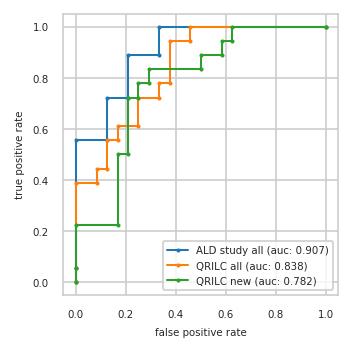

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.556     0.000 0.389     0.000 0.222
3          0.125 0.556     0.083 0.389     0.167 0.222
4          0.125 0.722     0.083 0.444     0.167 0.500
5          0.208 0.722     0.125 0.444     0.208 0.500
6          0.208 0.889     0.125 0.556     0.208 0.722
7          0.333 0.889     0.167 0.556     0.250 0.722
8          0.333 1.000     0.167 0.611     0.250 0.778
9          1.000 1.000     0.250 0.611     0.292 0.778
10           NaN   NaN     0.250 0.722     0.292 0.833
11           NaN   NaN     0.333 0.722     0.500 0.833
12           NaN   NaN     0.333 0.778     0.500 0.889
13           NaN   NaN     0.375 0.778     0.583 0.889
14           NaN   NaN     0.375 0.944     0.583 0.944
15           NaN   NaN     0.458 0.944     0.625 0.944
16           NaN   NaN     0.458 1.000     0.625 1.000
17           NaN   NaN     1.000 1.000     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,P31321
1,Q8NBI6,K7ERI9;P02654,A0A0C4DG76;Q5JZ08;Q9BQS7;Q9BQS7-2;Q9BQS7-3;Q9B...
2,Q16674;W4VSR3,A0A0A0MRJ7;P12259,P01704
3,P04075,P61981,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
4,P14174,P14174,D6R956;P09936
5,P61981,Q9Y2T3;Q9Y2T3-3,P10644;P10644-2
6,Q9Y2T3;Q9Y2T3-3,P04075,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
7,P00338;P00338-3,A0A0C4DG76;Q5JZ08;Q9BQS7;Q9BQS7-2;Q9BQS7-3;Q9B...,B8ZZL8;P61604
8,Q6EMK4,P00338;P00338-3,Q9H492;Q9H492-2


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


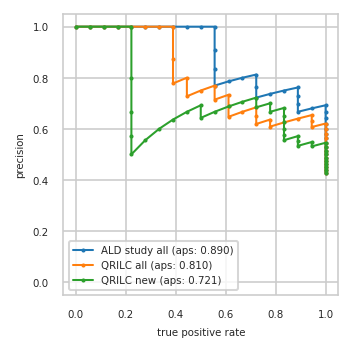

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.621 1.000     0.552 0.889
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.667 1.000     0.630 0.944     0.556 0.833
16         0.692 1.000     0.654 0.944     0.577 0.833
17         0.680 0.944     0.640 0.889     0.600 0.833
18         0.667 0.889     0.625 0.833     0.625 0.833
19         0.696 0.889     0.609 0.778     0.652 0.833
20         0.727 0.889     0.636 0.778     0.682 0.833
21         0.762 0.889     0.619 0.722     0.667 0.778
22         0.750 0.833     0.650 0.722     0.700 0.778
23         0.737 0.778     0.684 0.722     0.684 0.722
24         0.722 0.722     0.667 0.667     0.722 0.722
25         0.765 0.722     0.647 0.611     0.706 0.667
26         0.812 0.722     0.688 0.611     0.688 0.611
27         0.800 0.667     0.733 0.611     0.667 0.556
28         0.786 0.611     0.714 0.556     0.643 0.500
29         0.769 0.556     0.769 0.556     0.692 0.500
30         0.833 0.556     0.750 0.500     0.667 0.444
31         0.909 0.556     0.727 0.444     0.636 0.389
32         1.000 0.556     0.800 0.444     0.600 0.333
33         1.000 0.500     0.778 0.389     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     1.000 0.222
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


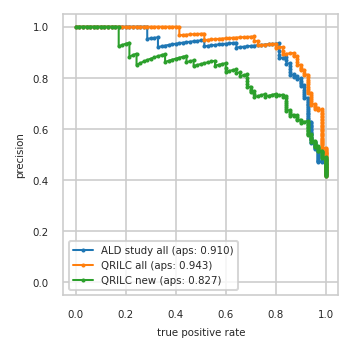

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


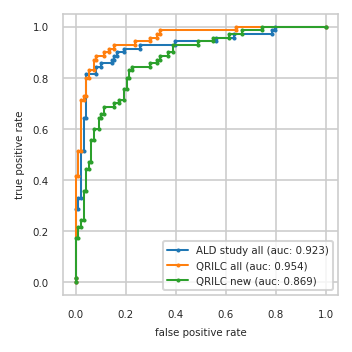

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}